In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap

# %matplotlib qt5
sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.5

labels = list(range(16))  # labels 0–15
tab20 = plt.get_cmap("tab20")

label_palette = {label: tab20(label) for label in labels}

In [2]:
from typing import Optional
import numbers

def auto_opt_pd_dtypes(df_: pd.DataFrame, inplace=False) -> Optional[pd.DataFrame]:
    """ Automatically downcast Number dtypes for minimal possible,
        will not touch other (datetime, str, object, etc)
        :param df_: dataframe
        :param inplace: if False, will return a copy of input dataset
        :return: `None` if `inplace=True` or dataframe if `inplace=False`
    """
    df_temp = df_ if inplace else df_.copy()
    print(df_temp.info())

    for col in df_temp.columns:
        # integers
        if issubclass(df_temp[col].dtypes.type, numbers.Integral):
            # unsigned integers
            if df_temp[col].min() >= 0:
                df_temp[col] = pd.to_numeric(df_temp[col], downcast='unsigned')
            # signed integers
            else:
                df_temp[col] = pd.to_numeric(df_temp[col], downcast='integer')
        # other real numbers
        elif issubclass(df_temp[col].dtypes.type, numbers.Real):
            df_temp[col] = pd.to_numeric(df_temp[col], downcast='float')

        elif issubclass(df_temp[col].dtypes.type, np.object_):
            df_temp[col] = pd.Categorical(df_temp[col])

    print(df_temp.info())
    if not inplace:
        return df_temp

In [3]:
df = pd.read_csv('kc_house_data.csv', header='infer', delimiter=',', parse_dates=['date'])
df = auto_opt_pd_dtypes(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [4]:
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,2014-10-29 04:38:01.959931648,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560051,-122.213898,1986.552492,12768.455652
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155899,-122.518997,399.000000,651.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471001,-122.328003,1490.000000,5100.000000
50%,3.904930e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230003,1840.000000,7620.000000
75%,7.308900e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678001,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777599,-121.315002,6210.000000,871200.000000
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631


In [5]:
df['sqft_basement'] = df['sqft_basement'].replace(0, np.nan)
df['yr_renovated'] = df['yr_renovated'].replace(0, np.nan)

In [6]:
# log-transform features
cols = [col for col in df.columns if col not in ('id', 'date')]
cols_log = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

In [7]:
df = df.loc[df['bedrooms'] < 30]

In [8]:
# create df with log features
df_log = df.copy()
df_log[cols_log] = np.log10(df_log[cols_log])
df_log['time_since_renovation'] = 2016 - df_log['yr_renovated']
df_log['age'] = 2016 - df_log['yr_built']

In [9]:
# modelling dataframe: removed highly correlated and redundant features
df_modelling = df_log.copy()

df_modelling = df_modelling[[col for col in df_modelling.columns if col not in ('zipcode', 'yr_built', 'yr_renovated', 'bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'sqft_lot15')]]

df_modelling = df_modelling.sort_values('date').groupby('id').agg('last').reset_index()  # remove duplicate houses, keep last sell entry
df_modelling.loc[df_modelling['time_since_renovation'].isna(), 'time_since_renovation'] = df_modelling['age']  # non renovated houses: set time since renovation to age
df_modelling = df_modelling.fillna(0)

In [10]:
# normalize modelling data
from sklearn.preprocessing import MinMaxScaler

cols_norm = [col for col in df_modelling.columns if col not in ('id', 'date')]
scaler = MinMaxScaler()
df_normalized = df_modelling.copy()
df_normalized[cols_norm] = scaler.fit_transform(df_modelling[cols_norm])

# PCA

In [11]:
num_data = df_modelling[cols_norm]

minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()

x = pd.DataFrame(data=standardscaler.fit_transform(num_data[cols_norm]), columns=cols_norm)

pca_input = x.dropna()
model = PCA()
pca_data = model.fit_transform(pca_input)

num_data = pd.concat([num_data, pd.DataFrame(pca_data, columns=[str(x) for x in range(len(cols_norm))])], axis=1)

In [12]:
pca_data.shape

(21435, 13)

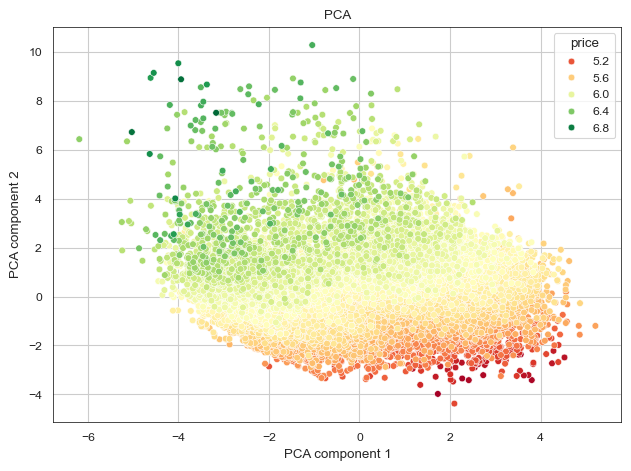

Explained variance by first 5 compononents: 0.726


In [13]:
sns.scatterplot(data=num_data.sort_values(by='price', ascending=True), x='0', y='1', hue='price', palette='RdYlGn')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('PCA')
plt.tight_layout()
plt.show()

print(f'Explained variance by first 5 compononents: {sum(model.explained_variance_ratio_[:5]):.3f}')

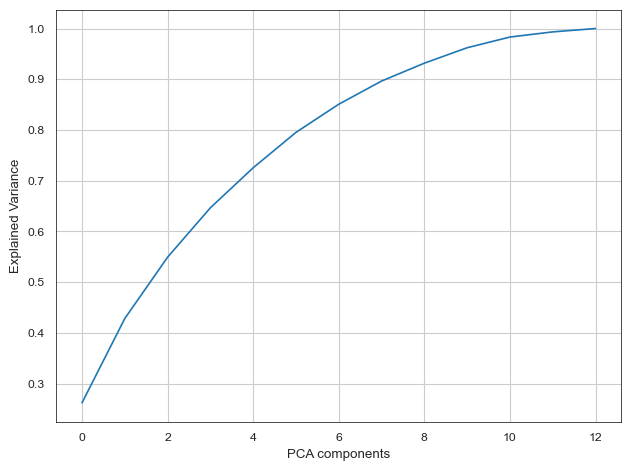

In [14]:
plt.plot(range(pca_data.shape[1]), model.explained_variance_ratio_.cumsum())
plt.xlabel('PCA components')
plt.ylabel('Explained Variance')
plt.tight_layout()

In [15]:
import numpy as np
from sklearn.cluster import HDBSCAN
import umap
from tqdm import tqdm

setting_cols = ['n_components', 'min_cluster_size_pct', 'min_cluster_size', 'min_samples', 'n_clusters',
                'noise_pct', 'silhouette_score', 'dbi_score']
df_settings = pd.DataFrame(columns=setting_cols)


for n_components in (6, 8, 10, 12):
    reducer = umap.UMAP(n_components=n_components)  # no random state for faster computation
    data = df_modelling[[col for col in df_modelling.columns if col not in ('id', 'date')]].values
    scaled_data = StandardScaler().fit_transform(data)
    embedding = reducer.fit_transform(scaled_data)
    # minimum cluster size as fraction of dataset size
    for mcs_pct in tqdm((0.05, 0.025, 0.01, 0.005)):
        mcs = round(len(df_modelling) * mcs_pct)
        min_samples_list = [round(i * mcs) for i in [0.5, 0.25, 0.1, 0.05]]
        for min_samples in min_samples_list:
            clusterer = HDBSCAN(
                min_cluster_size=mcs,
                min_samples=min_samples,
                metric="euclidean"
            )
            labels = clusterer.fit_predict(embedding)
    
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_frac = np.mean(labels == -1)
    
            temp = pd.DataFrame(data={'n_components': n_components,
                                      'min_cluster_size_pct': mcs_pct,
                                      'min_cluster_size': mcs,
                                      'min_samples': min_samples,
                                      'n_clusters': n_clusters,
                                      'noise_pct': noise_frac,
                                      'silhouette_score': silhouette_score(embedding, labels),
                                      'dbi_score': davies_bouldin_score(embedding, labels)
                                      },
                                index=[0])
            df_settings = pd.concat([df_settings, temp]).reset_index(drop=True)


KeyboardInterrupt



In [21]:
df_settings.to_csv('HDBSCAN_parameter_results.csv', index=False, sep=';', decimal=',')

In [16]:
df_settings = pd.read_csv('HDBSCAN_parameter_results.csv', sep=';', decimal=',')
n_obs = len(df_modelling)

df_settings = df_settings.copy()

df_settings['min_samples_pct'] = (
    df_settings['min_samples'] / df_settings['min_cluster_size']
)

# nicer categorical ordering
df_settings['min_samples_pct'] = df_settings['min_samples_pct'].round(2)

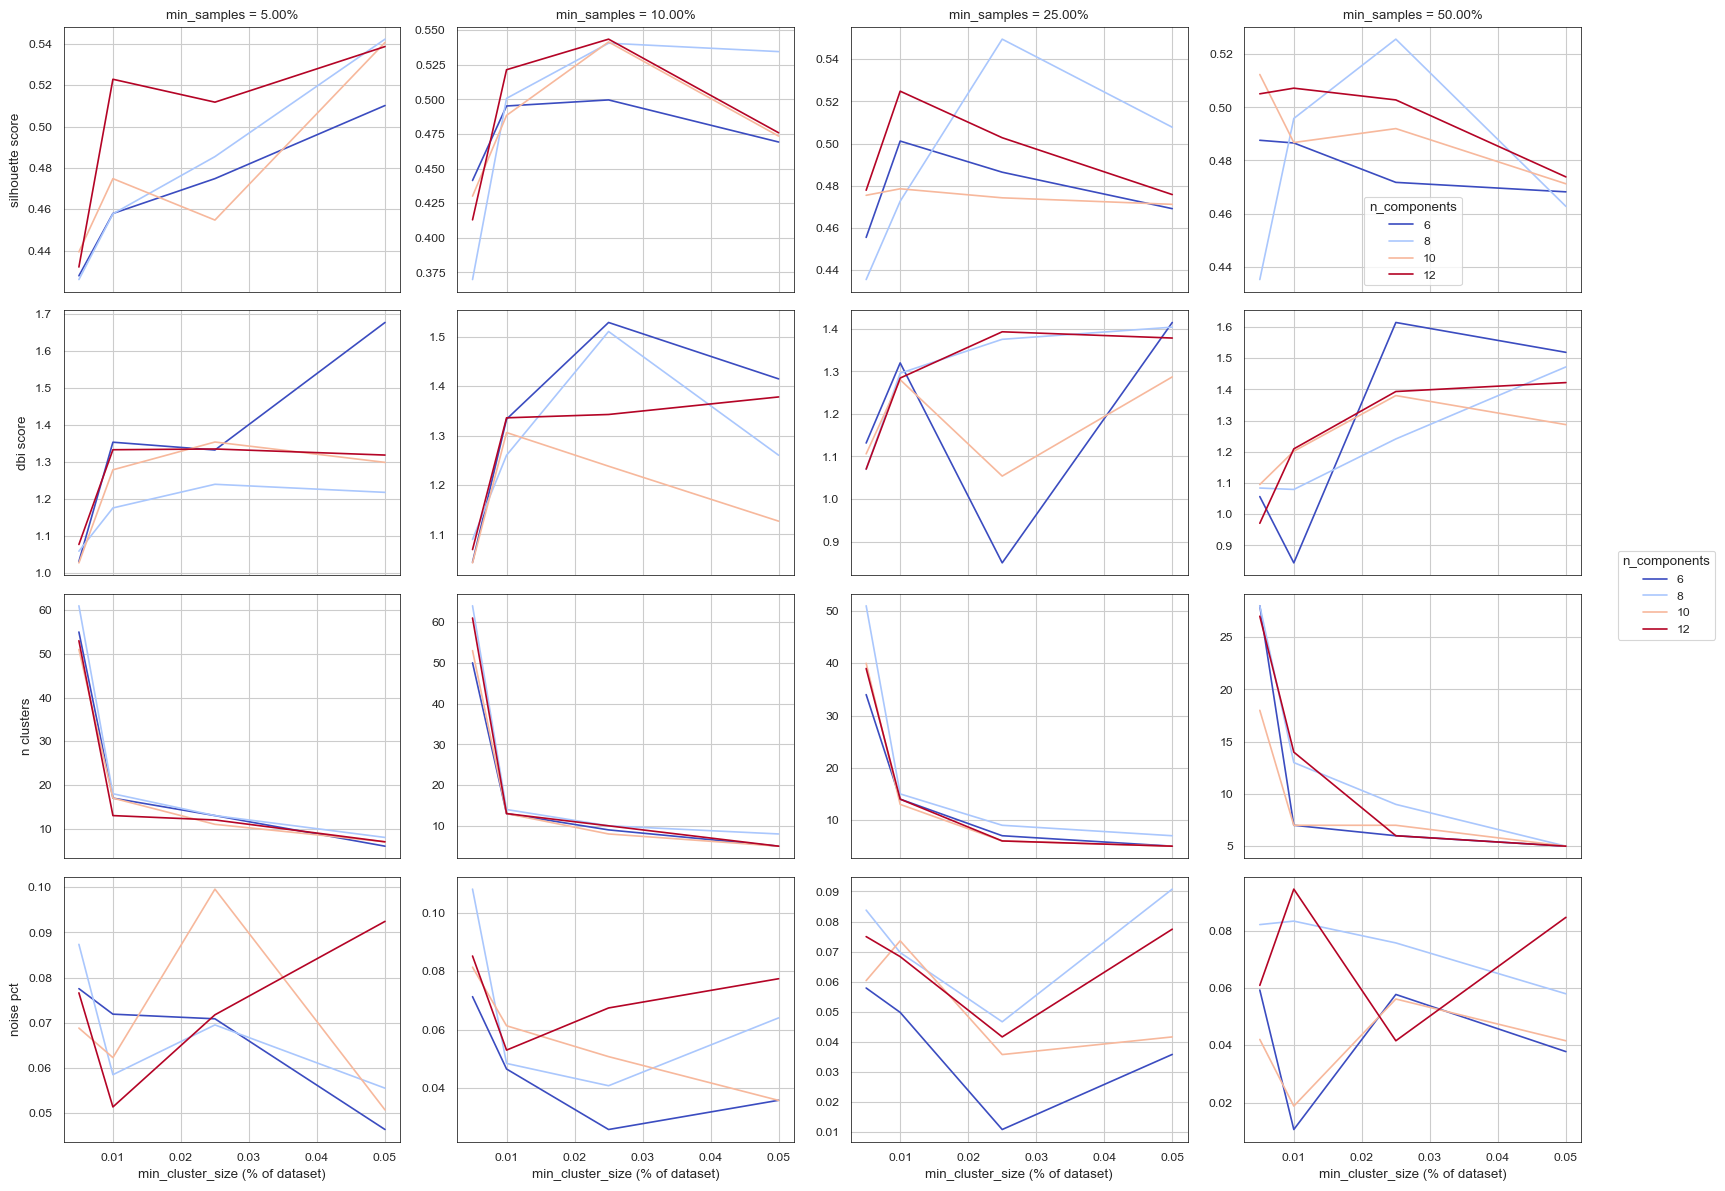

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

rows = [
    'silhouette_score',
    'dbi_score',
    'n_clusters',
    'noise_pct'
]

min_samples_pcts = sorted(df_settings['min_samples_pct'].unique())

fig, axes = plt.subplots(
    nrows=len(rows),
    ncols=len(min_samples_pcts),
    figsize=(4 * len(min_samples_pcts), 12),
    sharex=True
)

for col, ms_pct in enumerate(min_samples_pcts):
    temp_col = (
        df_settings[df_settings['min_samples_pct'] == ms_pct]
        .sort_values('min_cluster_size_pct')
    )

    for row, metric in enumerate(rows):
        ax = axes[row, col]

        sns.lineplot(
            data=temp_col,
            x='min_cluster_size_pct',
            y=metric,
            hue='n_components',
            palette='coolwarm',
            ax=ax
        )

        # column titles
        if row == 0:
            ax.set_title(f"min_samples = {ms_pct:.2%}")

        # row labels
        if col == 0:
            ax.set_ylabel(metric.replace('_', ' '))
        else:
            ax.set_ylabel("")

        # remove duplicate legends
        if not (row == 0 and col == len(min_samples_pcts) - 1):
            ax.legend_.remove()

# x-labels only on bottom row
for ax in axes[-1, :]:
    ax.set_xlabel("min_cluster_size (% of dataset)")

# shared legend
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title='n_components',
    loc='center left',
    bbox_to_anchor=(1.01, 0.5)
)

plt.tight_layout()
plt.show()

In [18]:
from sklearn.cluster import HDBSCAN

reducer = umap.UMAP(n_components=8, random_state=42)
data = df_modelling[[col for col in df_modelling.columns if col not in ('id', 'date')]].values
scaled_data = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled_data)

mcs = 150
min_samples = round(mcs * 0.5)
clusterer = HDBSCAN(
    min_cluster_size=mcs,
    min_samples=min_samples,
    metric="euclidean"
)
labels = clusterer.fit_predict(embedding)

C:\Users\bo112\PycharmProjects\DDM\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
silhouette_score(embedding, labels)

0.4225243031978607

In [23]:
davies_bouldin_score(embedding, labels)

1.4429338776716596

## 2D UMAP Clusters

In [19]:
data = df_modelling[cols_norm].values
scaled_data = StandardScaler().fit_transform(data)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_data)
df_results = pd.DataFrame(data=embedding)
df_results = pd.concat([df_results, df_modelling], axis=1)
df_results['label'] = labels

C:\Users\bo112\PycharmProjects\DDM\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


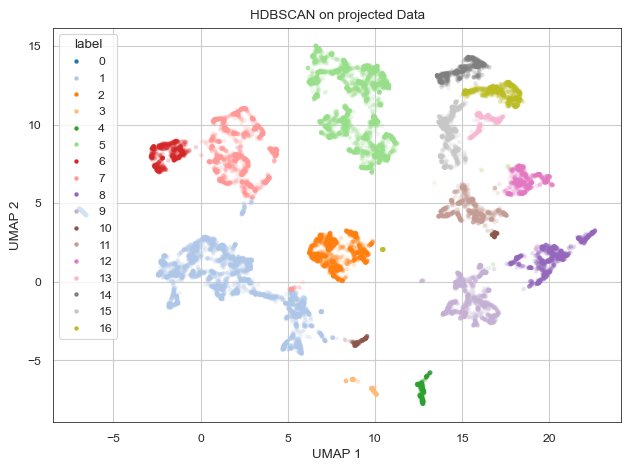

In [26]:
col = 'label'
results_sorted = df_results.sort_values(col)
results_sorted = results_sorted.loc[results_sorted['label'] != -1]
ax = sns.scatterplot(x=results_sorted.iloc[:, 0], y=results_sorted.iloc[:, 1], s=10, linewidth=0, hue=results_sorted[col], palette='tab20', alpha=0.2)

legend = ax.get_legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)
    
plt.title('HDBSCAN on projected Data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig('hierarchical_n6_ward_projected')

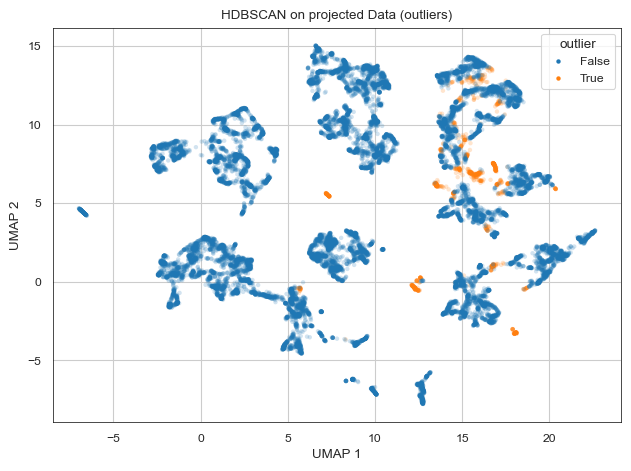

In [30]:
results_sorted = df_results.sort_values('label')
results_sorted['outlier'] = results_sorted['label'] == -1
ax = sns.scatterplot(x=results_sorted.iloc[:, 0], y=results_sorted.iloc[:, 1], s=10, linewidth=0, hue=results_sorted['outlier'], palette='tab10', alpha=0.2)

legend = ax.get_legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)
    
plt.title('HDBSCAN on projected Data (outliers)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig('hierarchical_n6_ward_projected')

# Hierarchical clustering

In [31]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Best model (see param search at the end of the notebook)

In [64]:
reducer = umap.UMAP(n_components=12, random_state=42)
data = df_modelling[[col for col in df_modelling.columns if col not in ('id', 'date')]].values
scaled_data = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled_data)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=None, n_clusters=16, linkage='average')

model = model.fit(embedding)
labels = model.labels_

C:\Users\bo112\PycharmProjects\DDM\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# can only be used when setting distance threshold instead of number of clusters
plot_dendrogram(model, p=5, truncate_mode='level')
plt.tight_layout()

In [33]:
silhouette_score(embedding, labels)

0.6470334529876709

In [34]:
davies_bouldin_score(embedding, labels)

0.4271051303726358

In [65]:
# recombine labels with original data and run UMAP with 2 components for visualization
data = df_modelling[cols_norm].values
scaled_data = StandardScaler().fit_transform(data)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(scaled_data)
df_results = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])
df_results = pd.concat([df_results, df_modelling], axis=1)
df_results['label'] = labels
df_results['grade'] = df_log['grade']
df_results = df_results.loc[df_results['label'] != 13]  # removed 'outlier' label

C:\Users\bo112\PycharmProjects\DDM\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


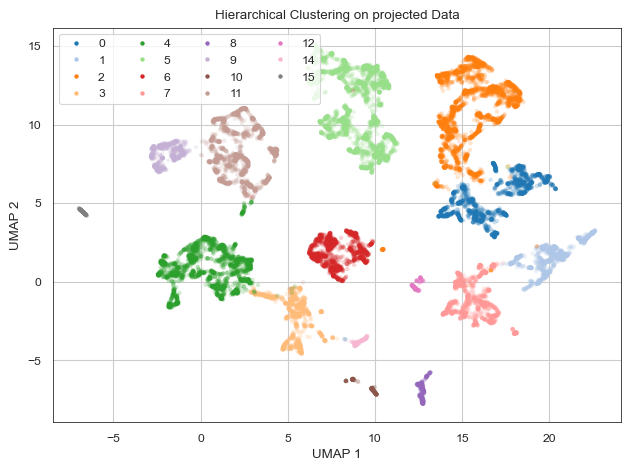

In [66]:
col = 'label'
results_sorted = df_results.sort_values(col)
ax = sns.scatterplot(x=results_sorted.iloc[:, 0], y=results_sorted.iloc[:, 1], s=10, linewidth=0, hue=results_sorted[col], palette='tab20', alpha=0.2)

ax.legend(ncol=4, loc='upper left')
legend = ax.get_legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)
    
plt.title('Hierarchical Clustering on projected Data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig('hierarchical_n6_ward_projected')

## Save log data

Group data by clusters and calculate metrics for comparison/manual merging into categories

In [36]:
# cols_log_post = list(set(cols_log) & set(df_modelling.columns))
# df_results[cols_log_post] = 10**df_results[cols_log_post]
# df_results[cols_log_post] = df_results[cols_log_post].replace(1, 0)

df_results['renovated'] = df_results['age'] != df_results['time_since_renovation']
df_results['years_until_renovation'] = df_results['age'] - df_results['time_since_renovation']
df_results['years_until_renovation_none'] = df_results['years_until_renovation'].replace(0, None)
# cluster_data = df_results.groupby('label').agg(['mean', 'median', 'std'])
cluster_data = df_results.groupby('label').agg(['mean'])
cluster_sizes = df_results.groupby('label')['id'].agg(['count'])
cluster_data['cluster_size'] = cluster_sizes
cluster_data.reset_index(inplace=True)
cluster_data.fillna(0, inplace=True)

C:\Users\bo112\AppData\Local\Temp\ipykernel_25716\3573491985.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cluster_data.fillna(0, inplace=True)


After comparison, merge clusters into categories

In [37]:
# merging of clusters for housing categories
final_category_mapping = {
    "New Suburban (Family)": [0, 1, 7, 12],
    "Established Housing (w/o Basement)": [2, 5],
    "Established Housing (with Basement)": [4, 9, 11],
    "Luxurious": [6, 15],
    "Compact Urban Housing": [8, 10, 14],
    "Modern/Renovated": [3]
}

cluster_to_category = {
    cluster: cat
    for cat, clusters in final_category_mapping.items()
    for cluster in clusters
}

df_results["final_category"] = df_results["label"].map(cluster_to_category)
cluster_data["final_category"] = cluster_data["label"].map(cluster_to_category)

In [38]:
final_category_mapping.keys()

dict_keys(['New Suburban (Family)', 'Established Housing (w/o Basement)', 'Established Housing (with Basement)', 'Luxurious', 'Compact Urban Housing', 'Modern/Renovated'])

Save relabeled data

In [40]:
cluster_data.to_csv('results_hierarchical_ncomp12_nclusters16_linkage_avg_final_log.csv', index=False, sep=';', decimal=',')

In [41]:
df_results.to_csv('full_clustered_data_log.csv', index=False, sep=';', decimal=',')

## Same procedure but tranform log data back to original values

In [42]:
df_results = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])
df_results = pd.concat([df_results, df_modelling], axis=1)
df_results['label'] = labels
df_results['grade'] = df_log['grade']
df_results = df_results.loc[df_results['label'] != 13]

In [43]:
cols_log_post = list(set(cols_log) & set(df_modelling.columns))
df_results[cols_log_post] = 10**df_results[cols_log_post]
df_results[cols_log_post] = df_results[cols_log_post].replace(1, 0)

df_results['renovated'] = df_results['age'] != df_results['time_since_renovation']
df_results['years_until_renovation'] = df_results['age'] - df_results['time_since_renovation']
df_results['years_until_renovation_none'] = df_results['years_until_renovation'].replace(0, None)
# cluster_data = df_results.groupby('label').agg(['mean', 'median', 'std'])
cluster_data = df_results.groupby('label').agg(['mean'])
cluster_sizes = df_results.groupby('label')['id'].agg(['count'])
cluster_data['cluster_size'] = cluster_sizes
cluster_data.reset_index(inplace=True)
cluster_data.fillna(0, inplace=True)

C:\Users\bo112\AppData\Local\Temp\ipykernel_25716\2243763223.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cluster_data.fillna(0, inplace=True)


In [44]:
df_results["final_category"] = df_results["label"].map(cluster_to_category)
cluster_data["final_category"] = cluster_data["label"].map(cluster_to_category)

In [45]:
cluster_data.to_csv('results_hierarchical_ncomp12_nclusters16_linkage_avg_final_real.csv', index=False, sep=';', decimal=',')

In [46]:
df_results.to_csv('full_clustered_data_real.csv', index=False, sep=';', decimal=',')

'full_clustered_data_real.csv' can be used for the interactive map (dash_map.py)

# Visualizations

In [47]:
# assign fixed colors to categories
tab10 = plt.get_cmap("tab10")
clusters_palette = {list(final_category_mapping.keys())[cluster_id]: tab10(cluster_id) for cluster_id in range(len(final_category_mapping.keys()))}

In [48]:
df_results.columns

Index(['UMAP 1', 'UMAP 2', 'id', 'date', 'price', 'bedrooms', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'lat', 'long', 'time_since_renovation', 'age', 'label',
       'grade', 'renovated', 'years_until_renovation',
       'years_until_renovation_none', 'final_category'],
      dtype='object')

In [49]:
df_results['renovated'] = df_results['renovated'].astype(int)

save box/hist plots for each feature for validating categories -> split into original labels

In [51]:
kind = 'box'

for feature in tqdm(df_results.iloc[:, 4:].columns):
    if feature == 'label':
        continue
    if feature in ('bedrooms', 'waterfront', 'view', 'condition', 'renovated', 'age'):
        discrete = True
    else:
        discrete = False
    try:
        x_delta = (df_results[feature].max() - df_results[feature].min()) * 0.05
        x_lims = (df_results[feature].min() - x_delta, df_results[feature].max() + x_delta)
    
        fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 8))
        axes = axes.flatten()
    
        for i, cluster in enumerate(final_category_mapping.keys()):
            ax = axes[i]
            if kind == 'hist':
                sns.histplot(df_results.loc[df_results['final_category'] == cluster], x=feature, hue='label', multiple='stack', palette=label_palette, linewidth=0, alpha=0.8, ax=ax, stat='percent', discrete=discrete)
            elif kind == 'box':
                sns.boxplot(df_results.loc[df_results['final_category'] == cluster], x='label', y=feature, hue='label', palette=label_palette, ax=ax)
            else:
                break
            ax.set_title(f'{cluster}')
    
        plt.tight_layout()
        if kind == 'hist':
            plt.savefig(f'plots/superclusters/{feature}_hist.png')
        elif kind == 'box':
            plt.savefig(f'plots/superclusters/{feature}_box.png')
        else:
            print('wrong kind')
            break
        plt.clf()

    except ValueError as e:
        print(e)
    except TypeError as e:
        pass

100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

old plotting function, can be ignored

In [52]:
# plot_type = 'kde'
# # plot_type = 'box'
# 
# # cluster_col = 'label'
# cluster_col = 'final_category'
# other_col = list({'label', 'final_category'} - {cluster_col})[0]
# 
# palette = 'tab20' if cluster_col == 'label' else 'tab10'
# 
# if plot_type == 'box':
#     fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 10), sharex=True)
# elif plot_type == 'kde':
#     fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 10))
# else:
#     pass
# 
# index = 0
# axs = axs.flatten()
# 
# cols_remove = ['bedrooms', 'floors', 'condition', 'view', 'renovated', 'waterfront', 'sqft_basement', 'time_since_renovation', 'years_until_renovation', other_col]
# cols_kde = list(set(df_results.iloc[:, 4:].columns) - set(cols_remove))
# 
# for k,v in df_results[cols_kde].items():
#     try:
#         if k in ['bedrooms', 'floors', 'condition', 'view', 'renovated']:
#             bw = 5
#         else:
#             bw = 1
#         scale = True if k in cols_log else False
#         
#         if k == cluster_col:
#             n_clusters = df_results[cluster_col].nunique()
#             axs[-1].bar(
#                 range(n_clusters),
#                 df_results.groupby(cluster_col)['id'].agg(['count'])['count'].values,
#                 color=sns.color_palette(palette)[:n_clusters],
#                 edgecolor="none"
#             )
#             axs[-1].set_xticks(range(n_clusters))
#             axs[-1].set_xticklabels(range(n_clusters))
#             axs[-1].set_xlabel('Cluster ID')
#             axs[-1].set_ylabel('Cluster size')
#             index -= 1
#         else:
#             if plot_type == 'kde':
#                 sns.kdeplot(x=k, data=df_results, ax=axs[index], log_scale=scale, hue=cluster_col, common_norm=False, palette=palette, multiple='fill', legend=False, linewidth=0, fill=True, bw_adjust=bw)
#             elif plot_type == 'box':
#                 sns.boxplot(df_results, x=cluster_col, y=k, ax=axs[index], hue=cluster_col, palette=palette, log_scale=scale, legend=False)
#                 axs[index].set_xlabel('Cluster ID')
#             else:
#                 pass
#     except ValueError as e:
#         pass
#     index += 1
#     
# plt.tight_layout()
# plt.show()

## UMAP visualizations

housing category visualization

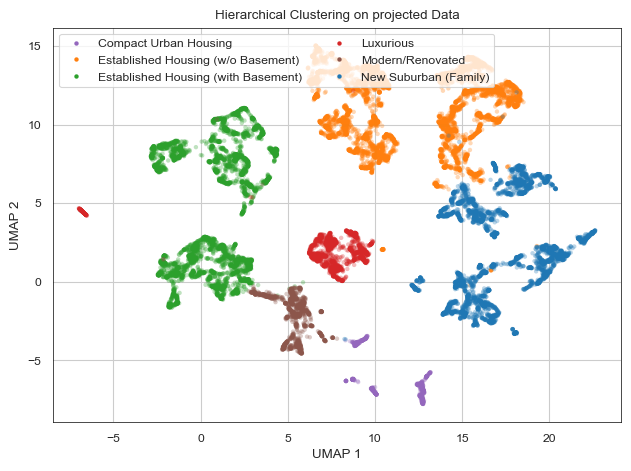

In [53]:
col = 'final_category'
palette = 'tab10'

results_sorted = df_results.sort_values(col)
# results_sorted[col] = results_sorted[col].astype(str)
ax = sns.scatterplot(data=results_sorted, x='UMAP 1', y='UMAP 2', s=10, linewidth=0, hue=col, alpha=0.3, palette=clusters_palette)

ax.legend(ncol=2, loc='upper left')
legend = ax.get_legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)

plt.title('Hierarchical Clustering on projected Data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.savefig('umap_final_clusters.png', dpi=500)

visualizing different features in UMAP space

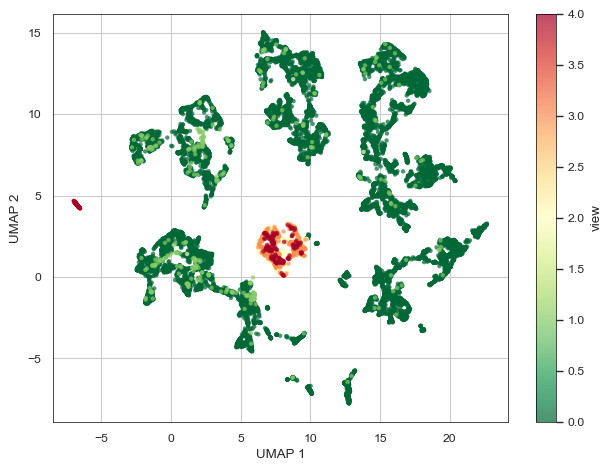

In [55]:
col = 'view'
palette = 'RdYlGn_r'

# col_filter = df_results[col] == 1
# results_sorted = df_results.loc[col_filter].sort_values(col)
results_sorted = df_results.sort_values(col, ascending=True)

sc = plt.scatter(
    results_sorted['UMAP 1'],
    results_sorted['UMAP 2'],
    c=results_sorted[col],
    cmap=palette,
    s=10,
    alpha=0.7,
    linewidths=0
)

plt.colorbar(sc, label=col)
# plt.title('Renovated Houses')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()

previous simple map visualization

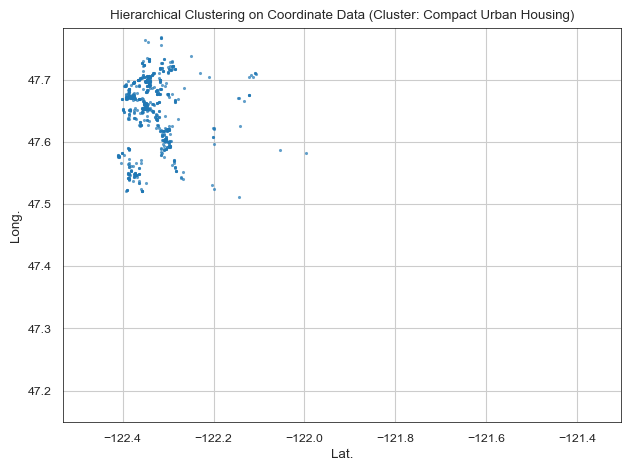

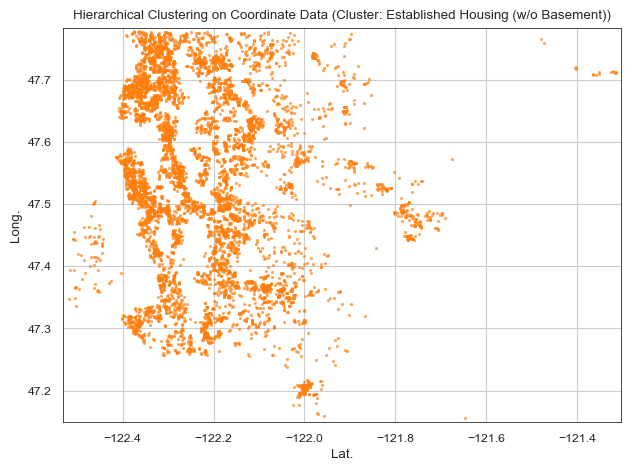

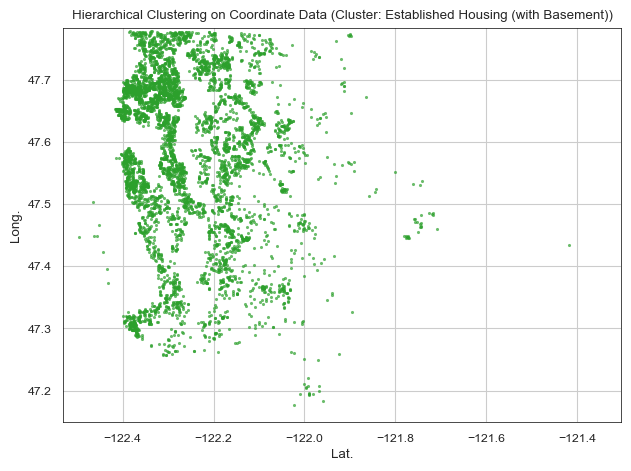

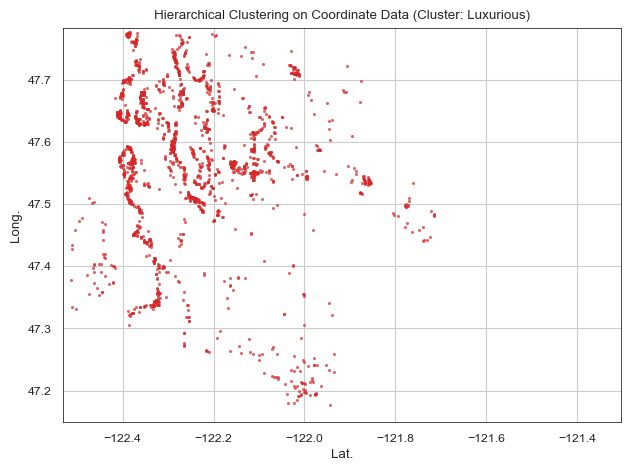

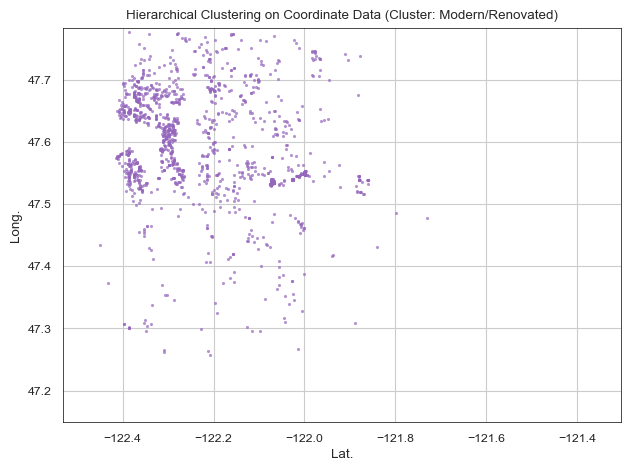

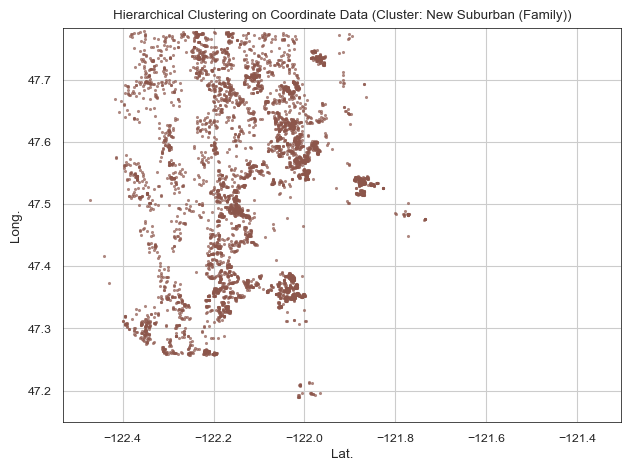

In [56]:
y_delta = (df_results['lat'].max() - df_results['lat'].min()) * 0.01
y_lims = (df_results['lat'].min() - y_delta, df_results['lat'].max() + y_delta)
x_delta = (df_results['long'].max() - df_results['long'].min()) * 0.01
x_lims = (df_results['long'].min() - x_delta, df_results['long'].max() + x_delta)

for i, cluster in enumerate(sorted(df_results['final_category'].unique())):
    ax = sns.scatterplot(df_results.loc[df_results['final_category'] == cluster], x='long', y='lat', color=sns.color_palette('tab10')[i], s=5, alpha=0.7, linewidth=0)
    
    # ax.legend(ncol=3, title='Cluster ID', loc='upper left')
    # legend = ax.get_legend()
    # for handle in legend.legend_handles:
    #     handle.set_alpha(1)
    
    plt.title(f'Hierarchical Clustering on Coordinate Data (Cluster: {cluster})')
    plt.xlabel('Lat.')
    plt.ylabel('Long.')
    plt.xlim(*x_lims)
    plt.ylim(*y_lims)
    plt.tight_layout()
    plt.show(block=True)

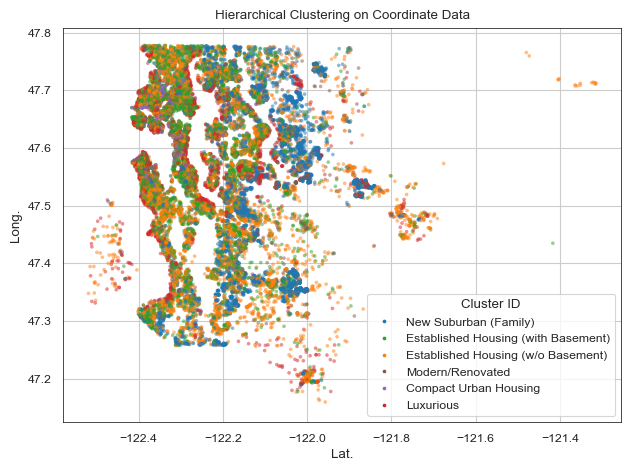

In [62]:
ax = sns.scatterplot(df_results, x='long', y='lat', hue='final_category', s=7, alpha=0.5, palette=clusters_palette, linewidth=0)

ax.legend(ncol=1, title='Cluster ID', loc='lower right')
legend = ax.get_legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)

plt.title('Hierarchical Clustering on Coordinate Data')
plt.xlabel('Lat.')
plt.ylabel('Long.')
plt.tight_layout()

# Hierarchical clustering parameter search

In [ ]:
from tqdm import tqdm

linkage_methods = ['average', 'complete', 'ward']
df_settings = pd.DataFrame(columns=['linkage', 'n_components', 'n_clusters', 'silhouette_score', 'dbi_score'])

for n in tqdm((6, 8, 10, 12)):
    reducer = umap.UMAP(n_components=n)
    data = df_modelling[[col for col in df_modelling.columns if col not in ('id', 'date')]].values
    scaled_data = MinMaxScaler().fit_transform(data)
    embedding = reducer.fit_transform(scaled_data)
    X = embedding
    for linkage in linkage_methods:
        print(linkage)
        for n_clusters in range(6, 19, 2):
            model = AgglomerativeClustering(distance_threshold=None, n_clusters=n_clusters, linkage=linkage)

            model = model.fit(X)
            labels = model.labels_

            temp = pd.DataFrame(data={'linkage': linkage,
                                      'n_components': n,
                                      'n_clusters': n_clusters,
                                      'silhouette_score': silhouette_score(X, labels),
                                      'dbi_score': davies_bouldin_score(X, labels)
                                      },
                                index=[0])
            df_settings = pd.concat([df_settings, temp]).reset_index(drop=True)

In [ ]:
df_settings.to_csv('param_search_hierarchical_fixed_age.csv', index=False, sep=';', decimal=',')

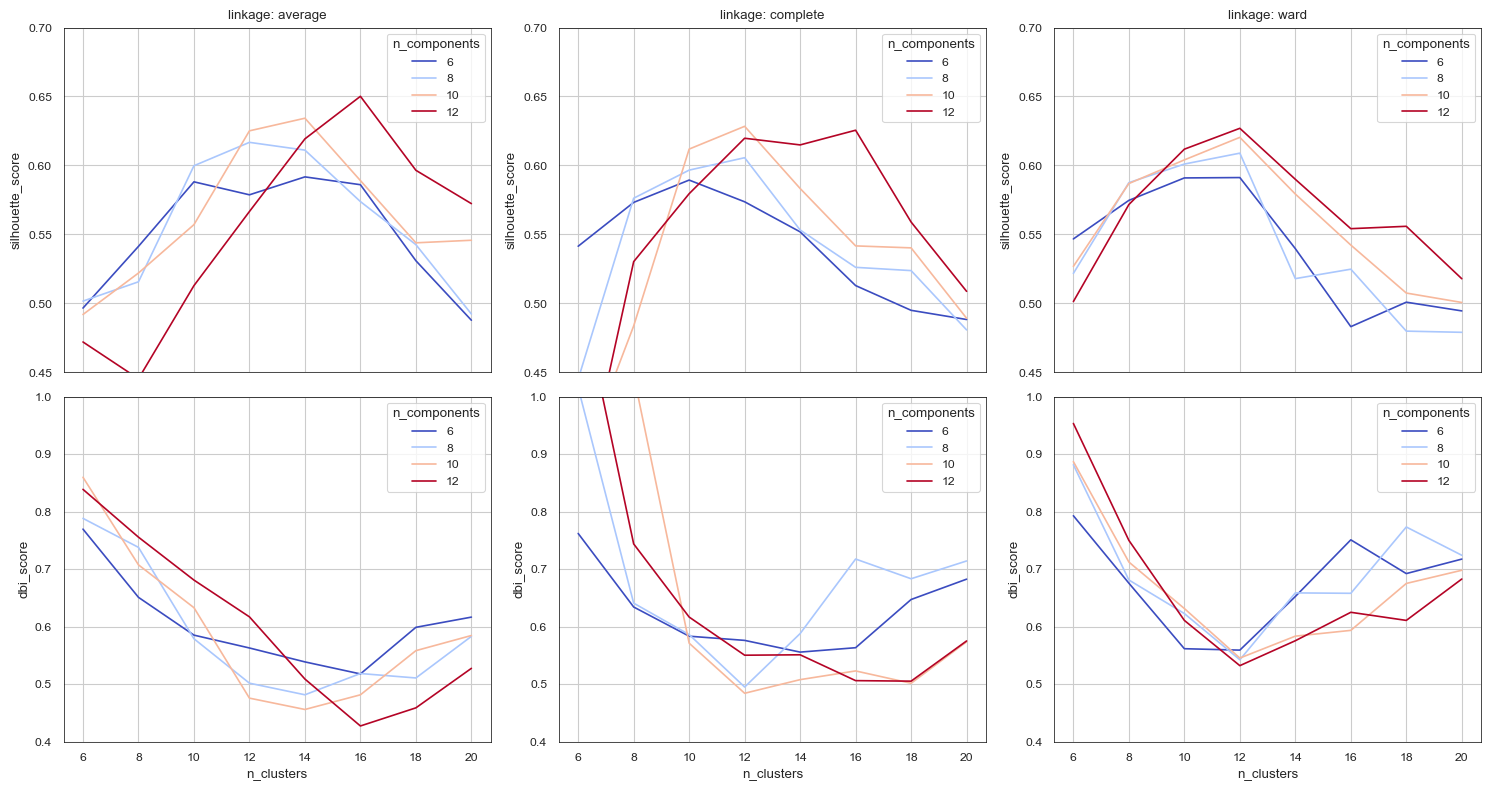

In [63]:
df_settings = pd.read_csv('param_search_hierarchical_fixed_age.csv', sep=';', decimal=',')
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15, 8))

for col, linkage in enumerate(('average', 'complete', 'ward')):
    temp = df_settings.loc[df_settings['linkage'] == linkage]
    for row, score in enumerate(('silhouette_score', 'dbi_score')):
        sns.lineplot(temp, x='n_clusters', y=score, hue='n_components', palette='coolwarm', ax=axes[row, col])
        if row == 0:
            axes[row, col].set_title(f'linkage: {linkage}')
        if score == 'silhouette_score':
            axes[row, col].set_ylim(0.45, 0.7)
        else:
            axes[row, col].set_ylim(0.4, 1)
        plt.tight_layout()
plt.show(block=True)